In [7]:
import pandas as pd
pd.options.display.max_rows = None
import matplotlib.pyplot as plt
import numpy as np
import datetime
cantonKeys = ['AG','AI','AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VD', 'VS', 'ZG','ZH']

dict = {}

for cantonId in cantonKeys:
    d = pd.read_csv("data/merged/"+cantonId+".csv")
    d = d.set_index('Time')
    dict[cantonId] = d

display(len(dict))




26

In [8]:
counter = 0
for col in dict['AG'].columns:
    print(col)
    counter = counter + 1
print(counter)

Cases entries 0 - 9
Cases entries 10 - 19
Cases entries 20 - 29
Cases entries 30 - 39
Cases entries 40 - 49
Cases entries 50 - 59
Cases entries 60 - 69
Cases entries 70 - 79
Cases entries 80+
Cases inz_entries 0 - 9
Cases inz_entries 10 - 19
Cases inz_entries 20 - 29
Cases inz_entries 30 - 39
Cases inz_entries 40 - 49
Cases inz_entries 50 - 59
Cases inz_entries 60 - 69
Cases inz_entries 70 - 79
Cases inz_entries 80+
Cases inzsumTotal 0 - 9
Cases inzsumTotal 10 - 19
Cases inzsumTotal 20 - 29
Cases inzsumTotal 30 - 39
Cases inzsumTotal 40 - 49
Cases inzsumTotal 50 - 59
Cases inzsumTotal 60 - 69
Cases inzsumTotal 70 - 79
Cases inzsumTotal 80+
Death entries 0 - 9
Death entries 10 - 19
Death entries 20 - 29
Death entries 30 - 39
Death entries 40 - 49
Death entries 50 - 59
Death entries 60 - 69
Death entries 70 - 79
Death entries 80+
Death inz_entries 0 - 9
Death inz_entries 10 - 19
Death inz_entries 20 - 29
Death inz_entries 30 - 39
Death inz_entries 40 - 49
Death inz_entries 50 - 59
Death 

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


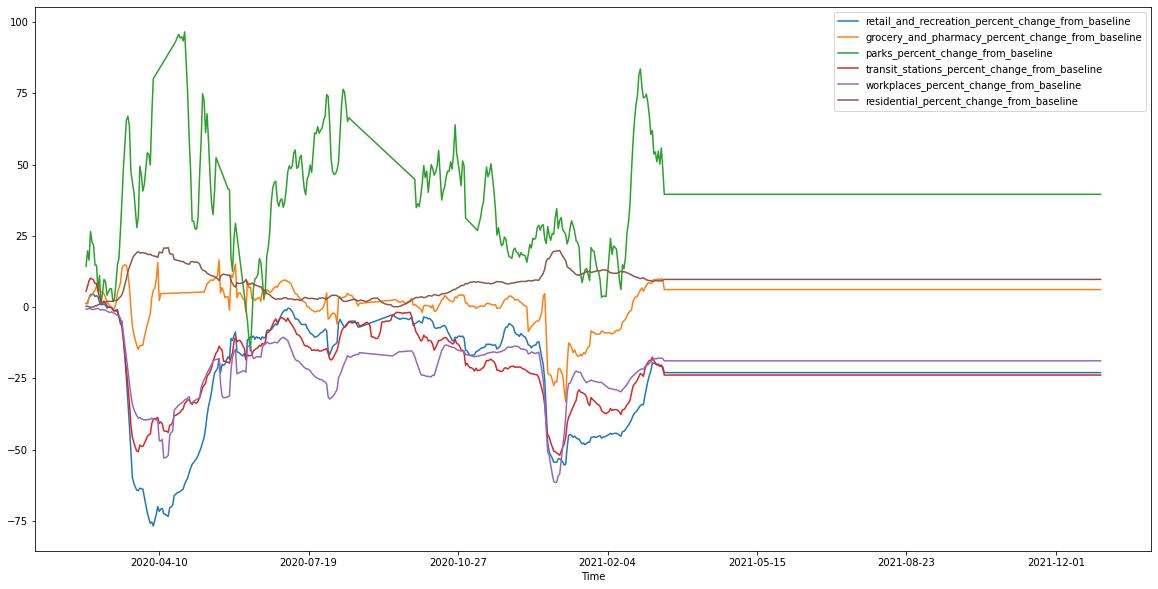

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


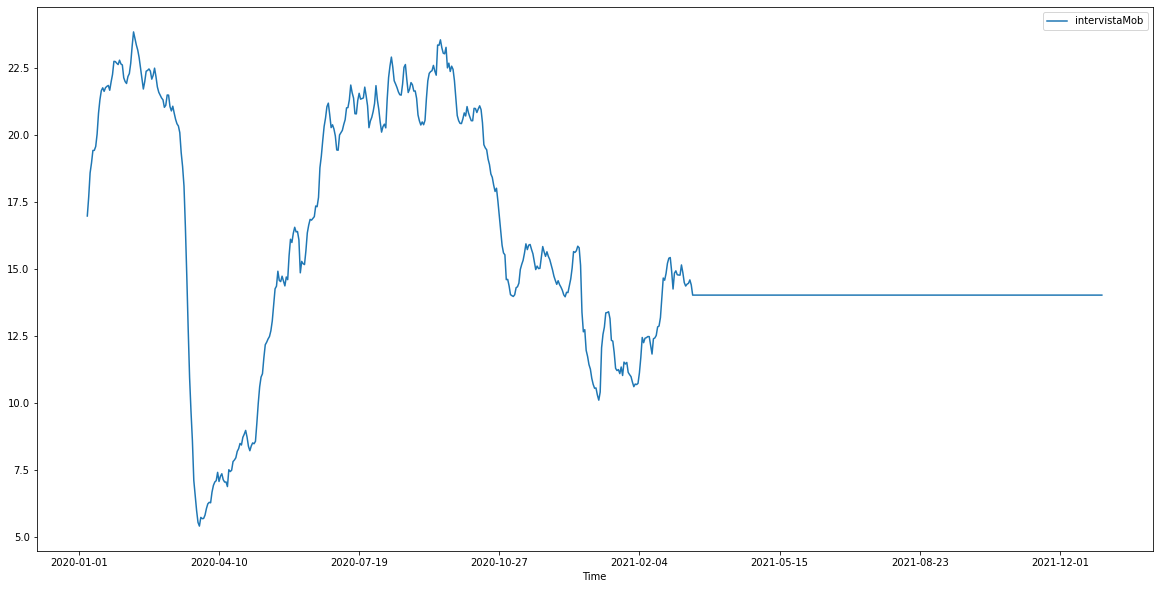

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


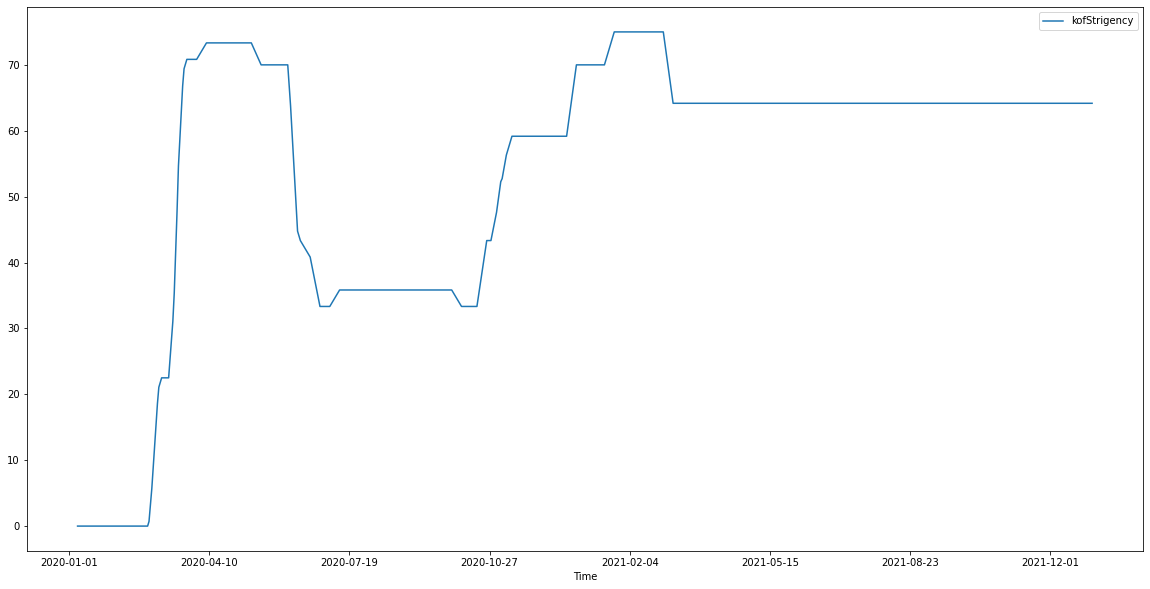

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


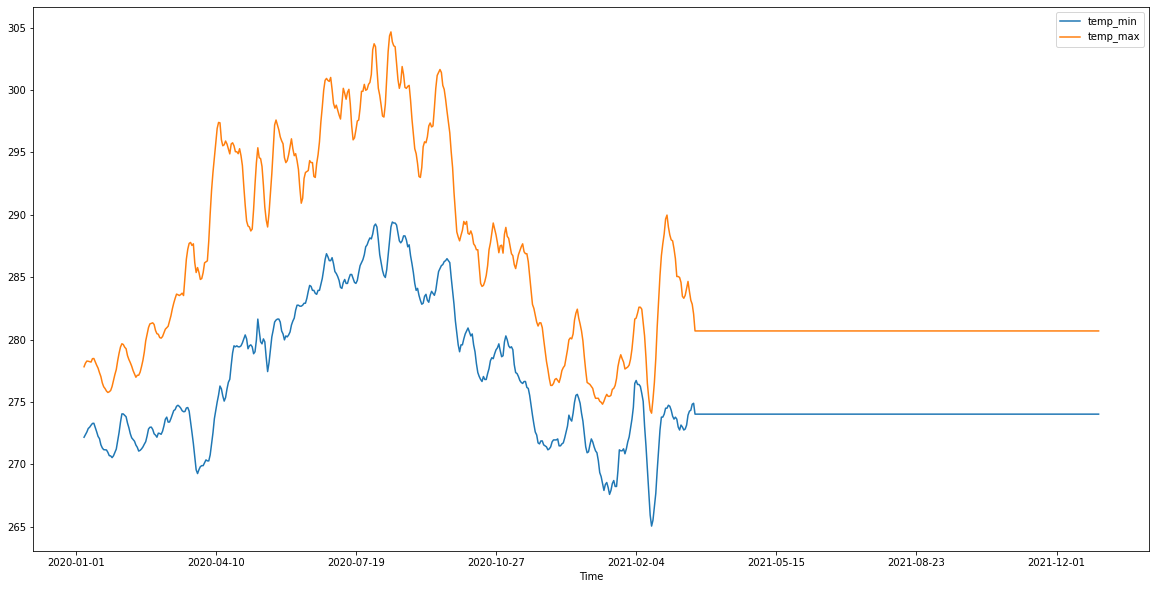

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


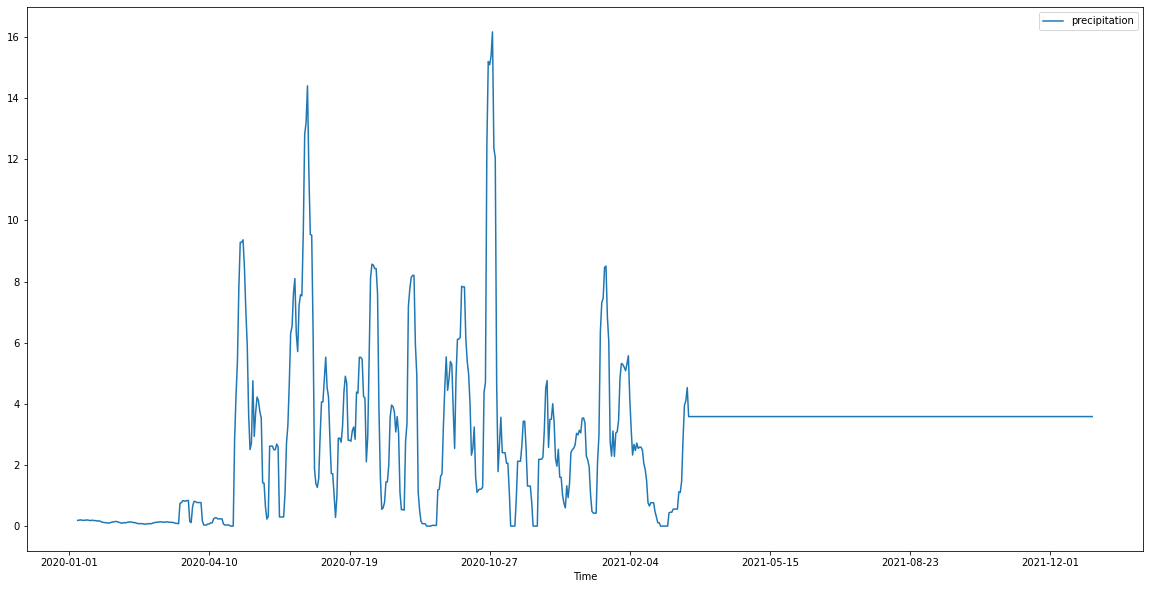

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


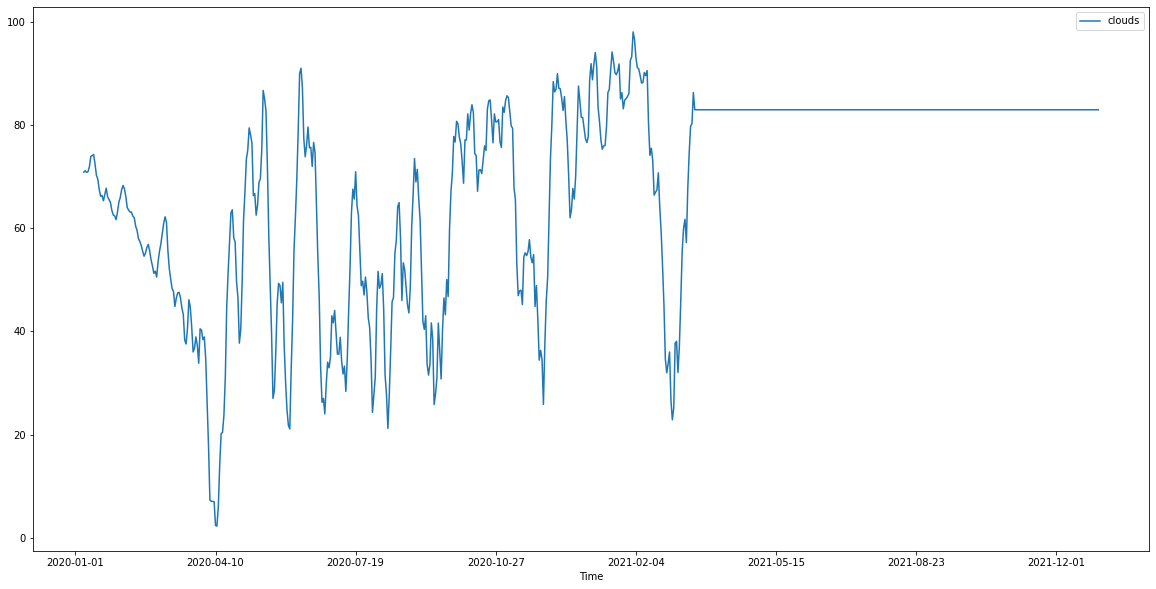

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


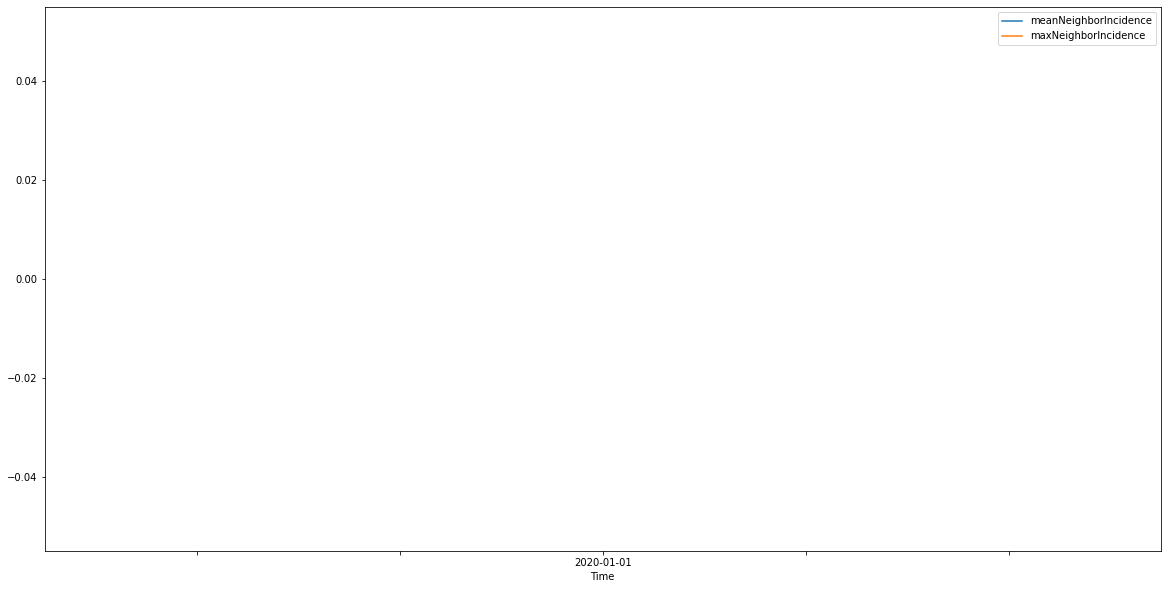

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


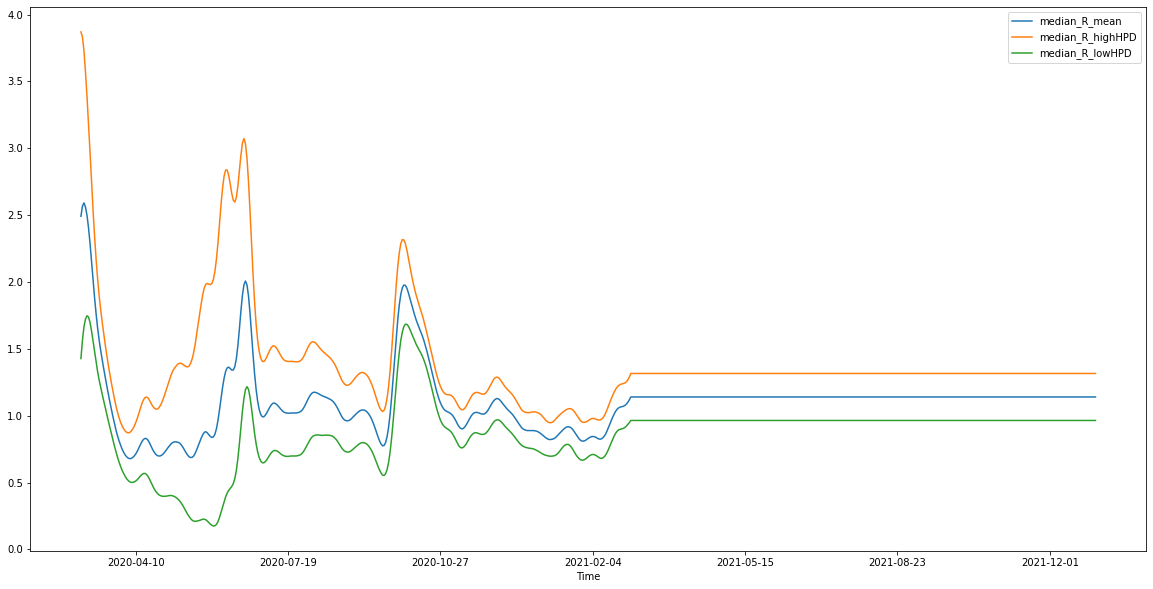

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


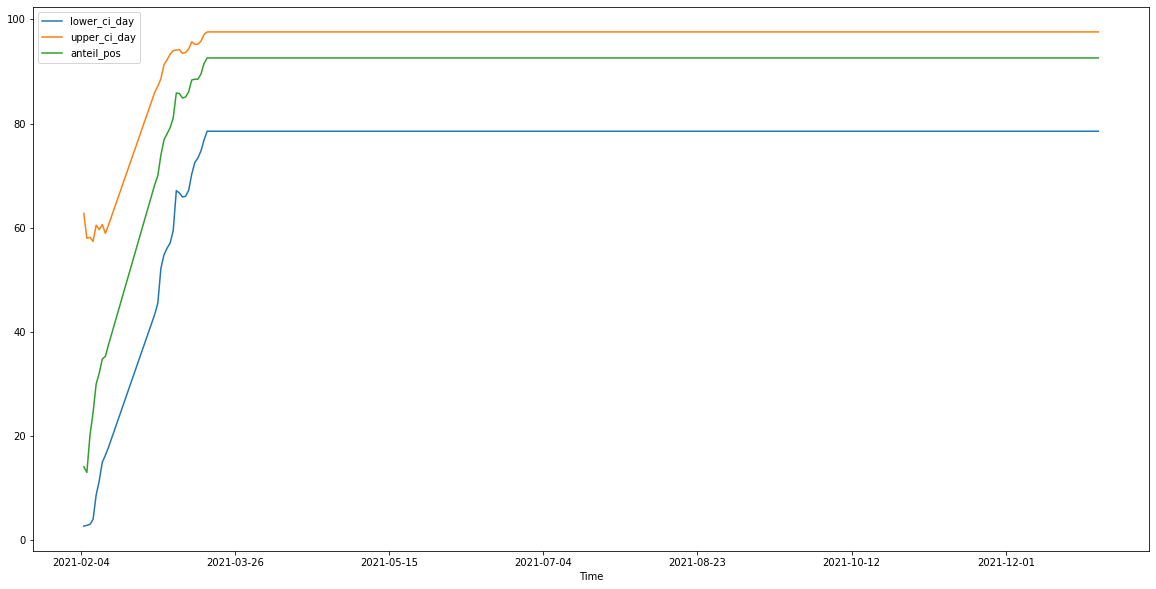

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


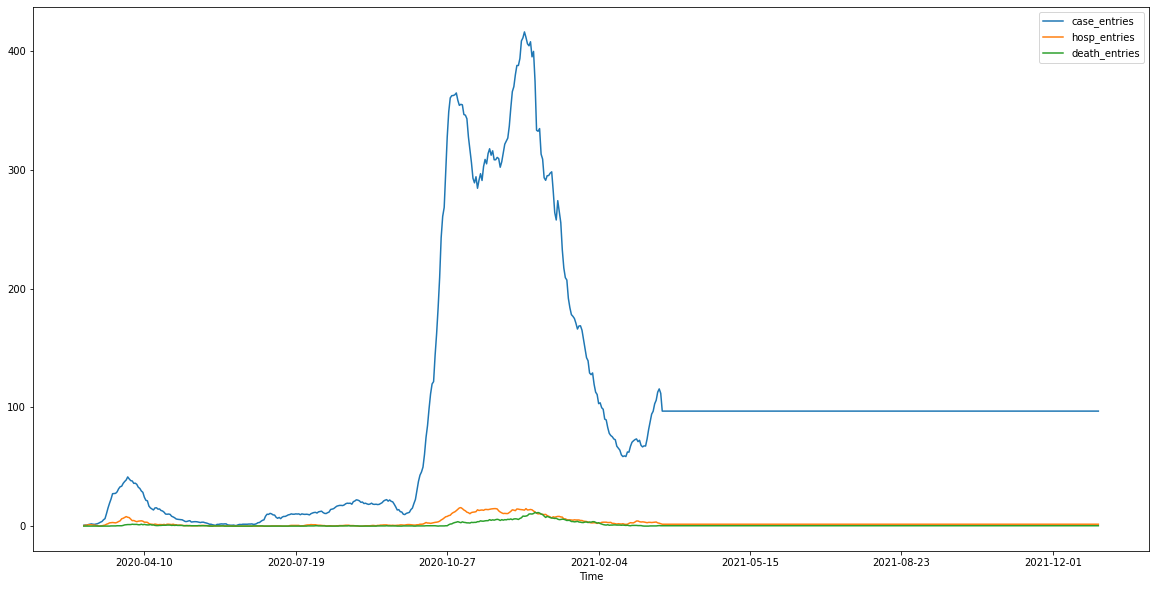

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


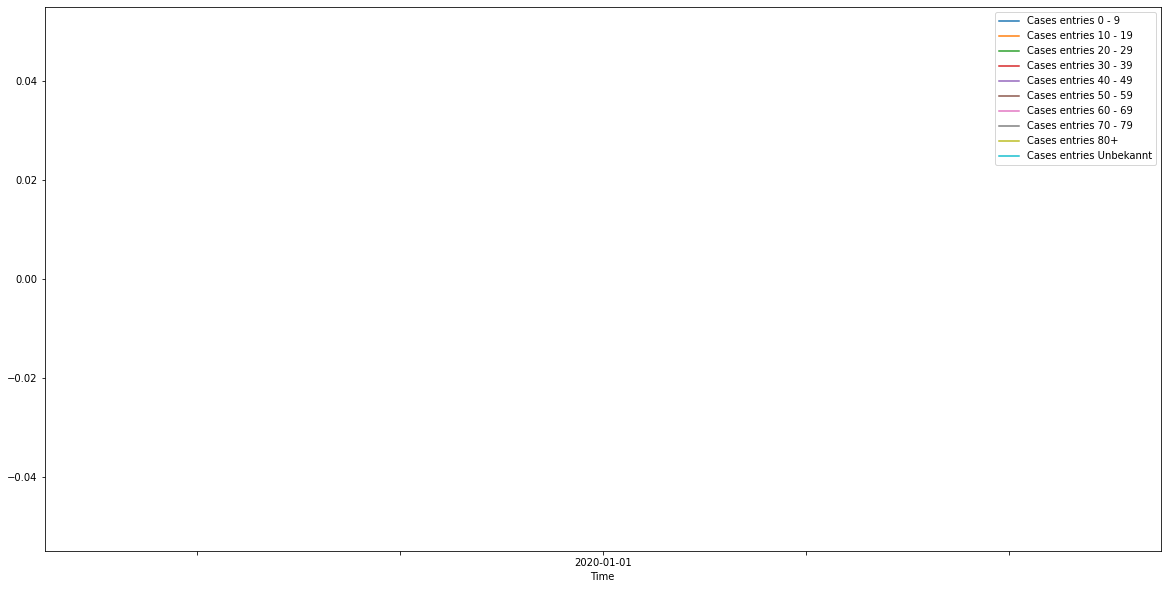

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


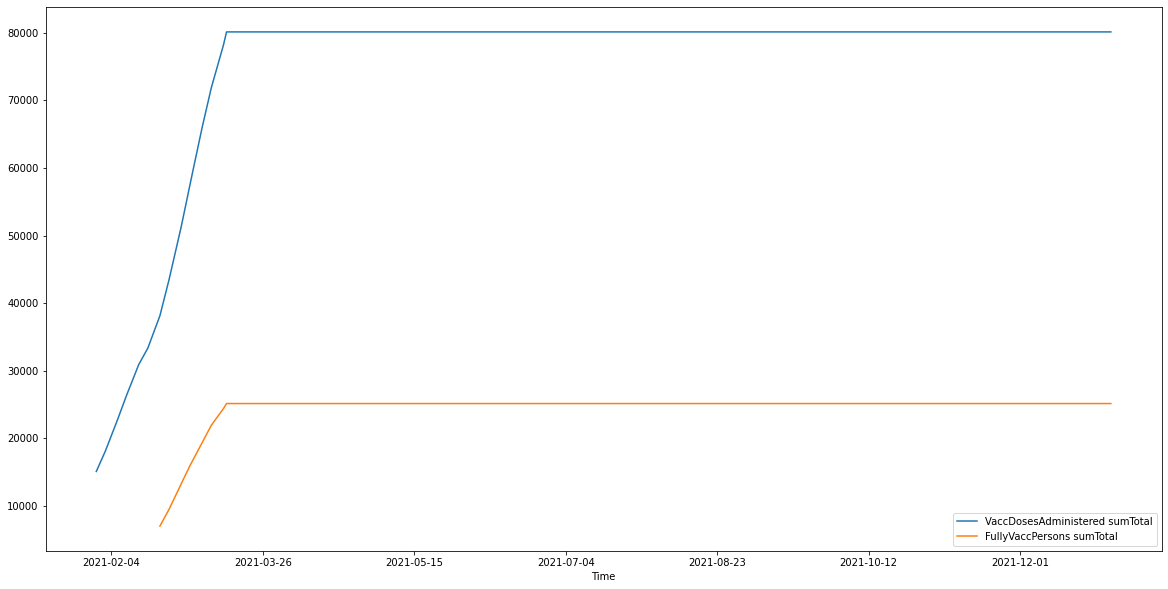

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


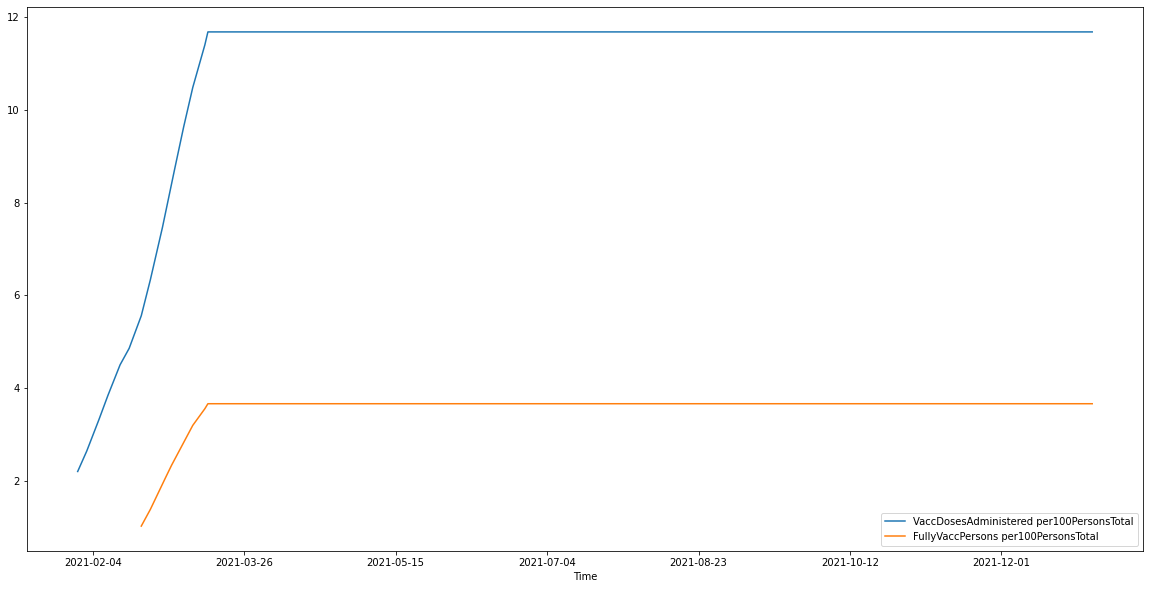

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


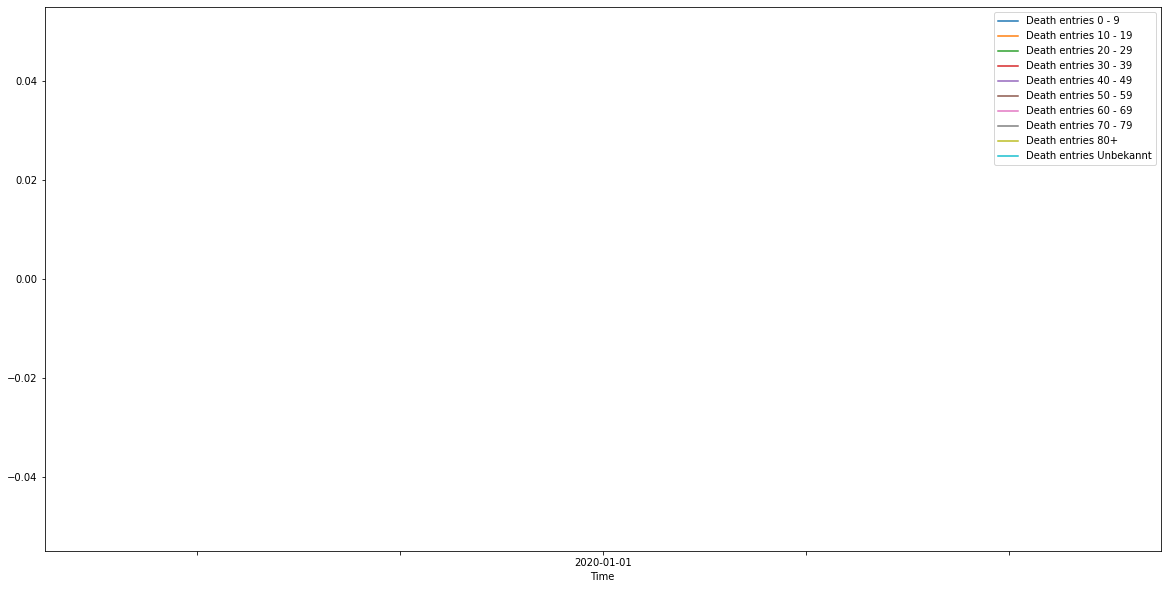

In [5]:
# exploring google mobility data

plotDict = {}

plotDict['googleMob'] = ['retail_and_recreation_percent_change_from_baseline','grocery_and_pharmacy_percent_change_from_baseline',
'parks_percent_change_from_baseline','transit_stations_percent_change_from_baseline',
'workplaces_percent_change_from_baseline','residential_percent_change_from_baseline']

plotDict['intervistaMob'] = ['intervistaMob']

plotDict['kof'] = ['kofStrigency']

plotDict['temperature'] = ['temp_min','temp_max']

plotDict['precipitation'] = ['precipitation']

plotDict['clouds'] =['clouds']

plotDict['neigbohr'] = ['meanNeighborIncidence','maxNeighborIncidence']

plotDict['rvalue'] = ['median_R_mean','median_R_highHPD','median_R_lowHPD']

plotDict['variant'] = ['lower_ci_day','upper_ci_day','anteil_pos']

plotDict['entries'] = ['case_entries','hosp_entries','death_entries']

plotDict['cases_agegroup'] = ['Cases entries 0 - 9','Cases entries 10 - 19','Cases entries 20 - 29','Cases entries 30 - 39',
                          'Cases entries 40 - 49','Cases entries 50 - 59','Cases entries 60 - 69','Cases entries 70 - 79',
                          'Cases entries 80+','Cases entries Unbekannt']

plotDict['vaccineSum'] = ['VaccDosesAdministered sumTotal','FullyVaccPersons sumTotal']

plotDict['vaccinePer100Person'] = ['VaccDosesAdministered per100PersonsTotal','FullyVaccPersons per100PersonsTotal']

plotDict['death'] = ['Death entries 0 - 9','Death entries 10 - 19','Death entries 20 - 29','Death entries 30 - 39',
                     'Death entries 40 - 49','Death entries 50 - 59','Death entries 60 - 69','Death entries 70 - 79',
                     'Death entries 80+','Death entries Unbekannt']

for colsOfInterest in plotDict:
    df = dict['AG']
    #df.index = pd.to_datetime(df.index)
    df[plotDict[colsOfInterest]].rolling(window=7).mean().interpolate(method='linear').plot(kind='line', y=plotDict[colsOfInterest], figsize=(20,10))
    plt.show()
    #.rolling(window=7).mean()

/Users/davidscherer/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


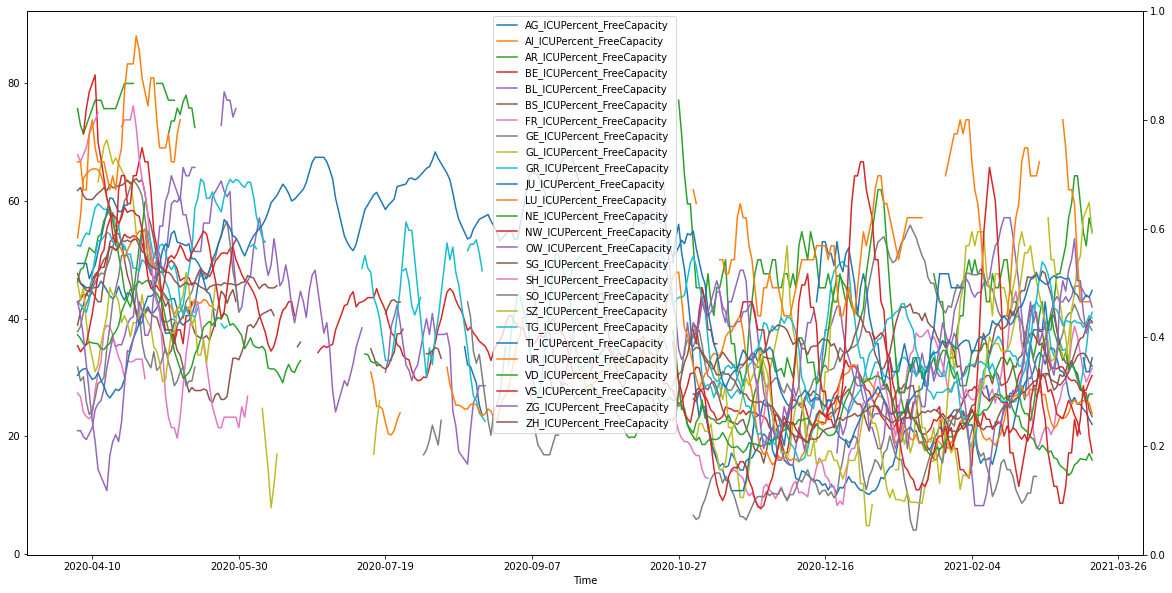

In [45]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
column = "ICUPercent_FreeCapacity"
for cantonId in cantonKeys:
    df = dict[cantonId].rename(columns = {column:cantonId+'_'+column}, inplace = False)
    df.rolling(window=7).mean().plot(y=[cantonId+'_'+column], ax=ax, figsize=(20,10))
plt.show()

In [72]:
from scipy.ndimage.interpolation import shift
copy = dict['AG'].copy()

dict['AG']['case_entries_shifted'] = np.roll(np.array(copy['case_entries']), 14)


corr_matrix = dict['AG'].corr()
display(corr_matrix['case_entries_shifted'].sort_values(ascending=False))

case_entries_shifted                                                         1.000000
meanNeighborIncidence                                                        0.924757
maxNeighborIncidence                                                         0.908173
Death inz_entries 80+                                                        0.868987
Death entries 80+                                                            0.868987
case_entries                                                                 0.865568
case_inz_entries                                                             0.865564
Death entries female                                                         0.864099
Death inz_entries female                                                     0.864054
Cases entries 80+                                                            0.858235
Cases inz_entries 80+                                                        0.858234
Death entries male                                    